In [10]:
import pandas as pd
import numpy as np
import openpyxl as xl
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.stattools import adfuller
from tabulate import tabulate
from statsmodels.tsa.stattools import acf,pacf
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm
import statsmodels.api as sm

In [11]:
df=pd.read_excel("FS_DATA_DAS.xlsx")
df

,Date,Recettes,Change,IPC
0,1998-10-01,4.511900e+08,16.3043,7.497835
1,1998-11-01,3.793800e+08,16.5948,8.022774
2,1998-12-01,3.967000e+08,16.5046,7.447713
3,1999-01-01,4.376500e+08,16.7778,7.375875
4,1999-02-01,4.147200e+08,16.8943,7.932369
...,...,...,...,...
307,2024-05-01,4.974492e+09,132.5137,28.300000
308,2024-06-01,6.102811e+09,132.2823,28.900000
309,2024-07-01,4.995281e+09,131.7522,30.000000
310,2024-08-01,4.843745e+09,131.5083,29.300000


In [12]:
# Différenciation simple (1re différence)
df['dRecettes'] = df['Recettes'] - df['Recettes'].shift(1)
df['dIPC'] = df['IPC'] - df['IPC'].shift(1)
df['dChange'] = df['Change'] - df['Change'].shift(1)


# Supprimer la première ligne (valeurs manquantes)
df_model = df.dropna()

df_model

,Date,Recettes,Change,IPC,dRecettes,dIPC,dChange
1,1998-11-01,3.793800e+08,16.5948,8.022774,-7.181000e+07,0.524939,0.2905
2,1998-12-01,3.967000e+08,16.5046,7.447713,1.732000e+07,-0.575061,-0.0902
3,1999-01-01,4.376500e+08,16.7778,7.375875,4.095000e+07,-0.071838,0.2732
4,1999-02-01,4.147200e+08,16.8943,7.932369,-2.293000e+07,0.556494,0.1165
5,1999-03-01,4.629400e+08,16.6816,7.941816,4.822000e+07,0.009447,-0.2127
...,...,...,...,...,...,...,...
307,2024-05-01,4.974492e+09,132.5137,28.300000,-6.952860e+06,1.000000,0.2144
308,2024-06-01,6.102811e+09,132.2823,28.900000,1.128319e+09,0.600000,-0.2314
309,2024-07-01,4.995281e+09,131.7522,30.000000,-1.107530e+09,1.100000,-0.5301
310,2024-08-01,4.843745e+09,131.5083,29.300000,-1.515362e+08,-0.700000,-0.2439


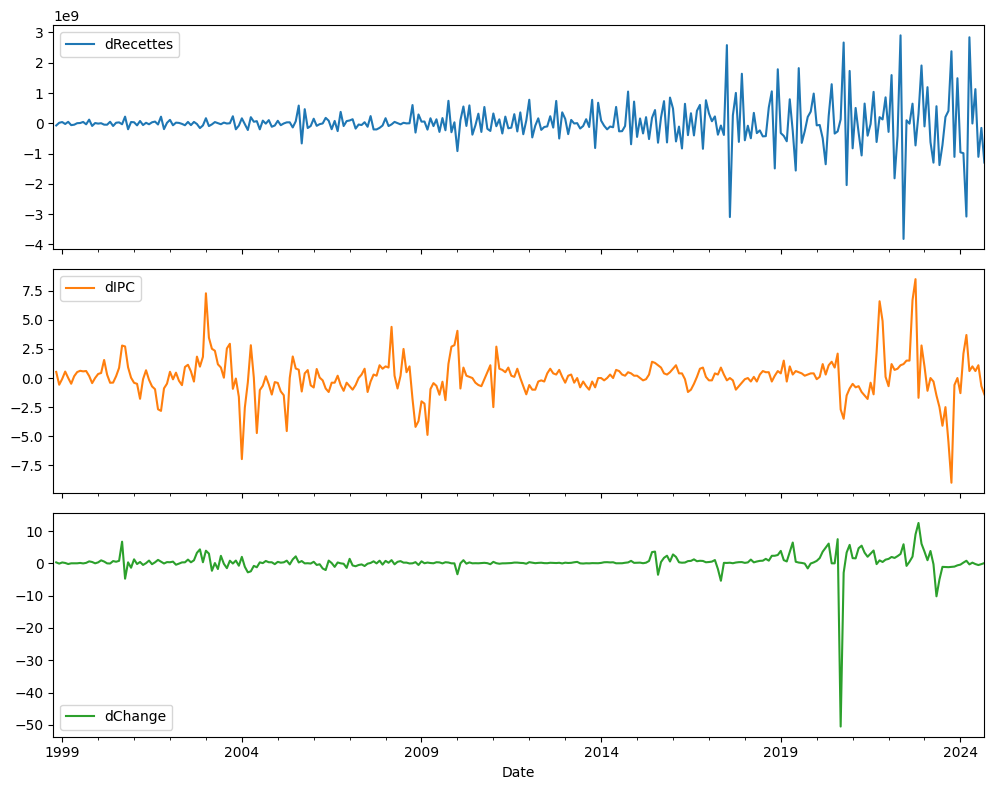

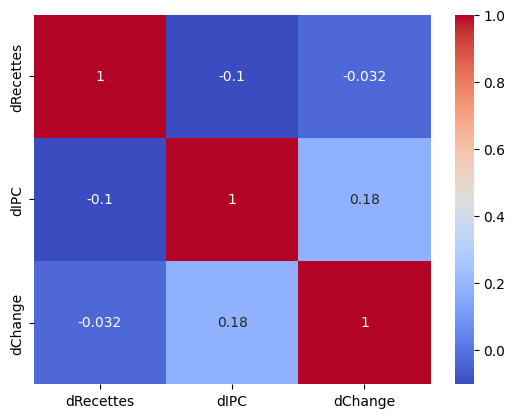

In [13]:
# Courbes d’évolution
df.set_index('Date')[['dRecettes', 'dIPC', 'dChange']].plot(subplots=True, figsize=(10, 8))
plt.tight_layout()
plt.show()

# Corrélations
sns.heatmap(df[['dRecettes', 'dIPC', 'dChange']].corr(), annot=True, cmap='coolwarm')
plt.show()

In [17]:
def adf_test(series, name):
    result = adfuller(series.dropna())
    print(f"ADF Test for {name}:")
    print(f"  ADF Statistic: {result[0]:.4f}")
    print(f"  p-value: {result[1]:.4f}")
    print("  Stationary" if result[1] < 0.05 else "  Non-stationary")
    print("-" * 40)

for col in ['dRecettes', 'dIPC', 'dChange']:
    adf_test(df_model[col], col)

ADF Test for dRecettes:
  ADF Statistic: -4.2034
  p-value: 0.0007
  Stationary
----------------------------------------
ADF Test for dIPC:
  ADF Statistic: -5.2502
  p-value: 0.0000
  Stationary
----------------------------------------
ADF Test for dChange:
  ADF Statistic: -16.1896
  p-value: 0.0000
  Stationary
----------------------------------------


In [18]:
# Étape 1 : Régression en difference premiere
X = df_model[['dIPC', 'dChange']]
X = sm.add_constant(X)
y = df_model['dRecettes']
model = sm.OLS(y, X).fit()

# Étape 2 : Tester la stationnarité des résidus
residuals = model.resid
result = adfuller(residuals)
print("ADF Statistic:", result[0])
print("p-value:", result[1])
print("  Stationary" if result[1] < 0.05 else "  Non-stationary")

ADF Statistic: -3.5700827190147555
p-value: 0.006359424202303447
  Stationary


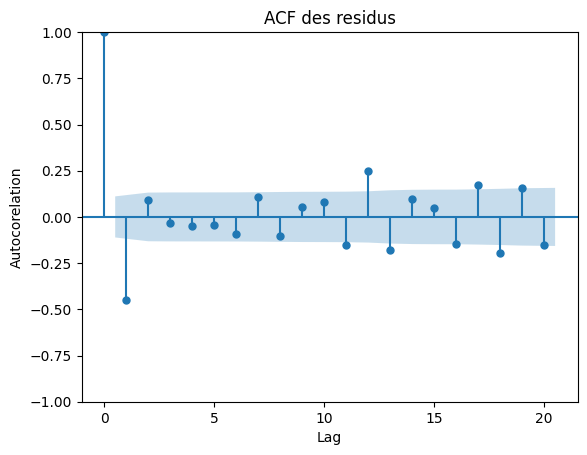

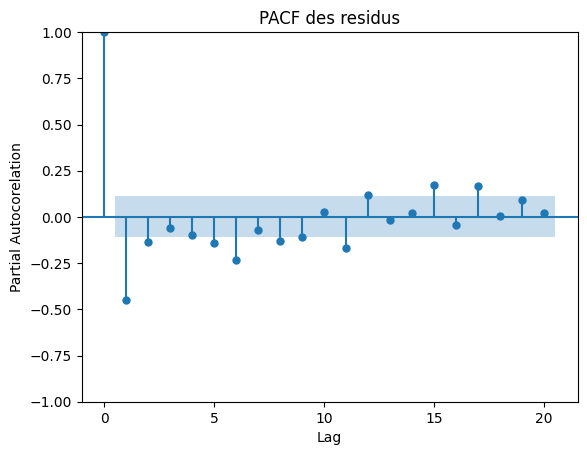

In [19]:
#tracer la fonction ACF des residus
plot_acf(residuals,lags=20)
plt.xlabel('Lag')
plt.ylabel('Autocorelation')
plt.title('ACF des residus')
plt.show()

#tracer la fonction PACF des residus
plot_pacf(residuals,lags=20)
plt.xlabel('Lag')
plt.ylabel('Partial Autocorelation')
plt.title('PACF des residus')
plt.show()

In [20]:
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              dRecettes   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     1.650
Date:                Wed, 25 Jun 2025   Prob (F-statistic):              0.194
Time:                        17:19:32   Log-Likelihood:                -6775.4
No. Observations:                 311   AIC:                         1.356e+04
Df Residuals:                     308   BIC:                         1.357e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.372e+07   4.01e+07      0.342      0.7

In [27]:
# Indexation temporelle 
df_model.index = pd.date_range(start='1998-10-01', periods=len(df_model), freq='M')

# 12 derniers mois = test
train_df = df_model.iloc[:-12]
test_df = df_model.iloc[-12:]

# X et y d'entraînement
X_train = sm.add_constant(train_df[['dIPC', 'dChange']])
y_train = train_df['dRecettes']

# Estimation sur train uniquement
model_train = sm.OLS(y_train, X_train).fit()

# X de test
X_test = sm.add_constant(test_df[['dIPC', 'dChange']])

In [28]:
# Prédiction sur train
train_pred = model_train.predict(X_train)

# Prédiction sur test
test_pred = model_train.predict(X_test)

# Concaténer les prédictions
all_pred = pd.concat([train_pred, test_pred])


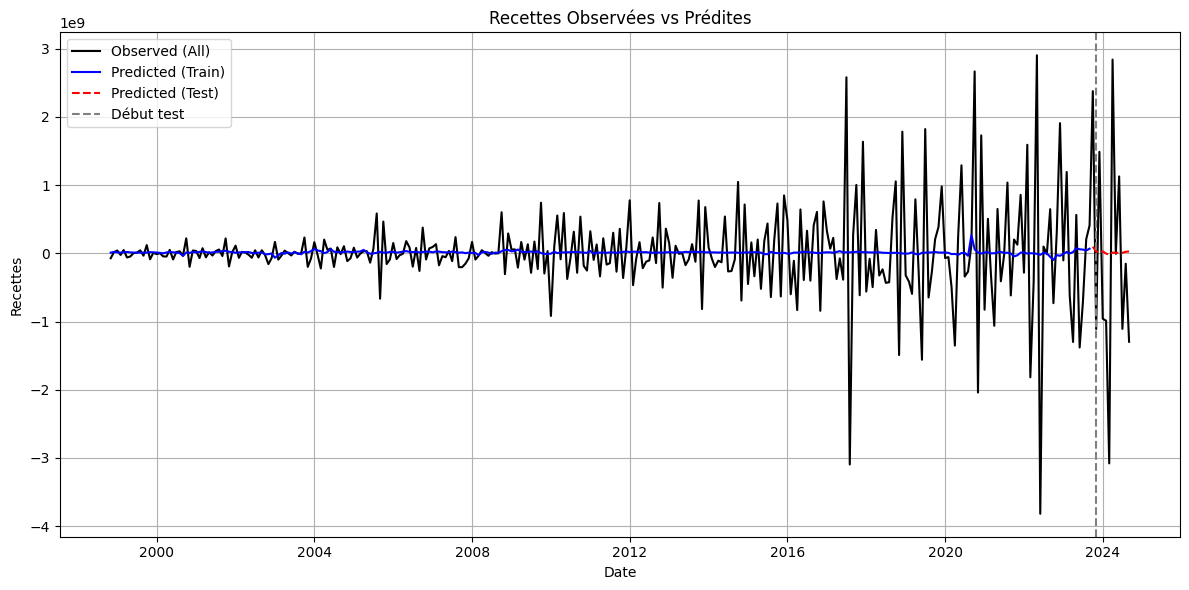

In [29]:
plt.figure(figsize=(12,6))

# Observé
plt.plot(df_model['dRecettes'], label='Observed (All)', color='black')
plt.plot(train_pred, label='Predicted (Train)', color='blue')
plt.plot(test_pred, label='Predicted (Test)', color='red', linestyle='--')

# Zones
plt.axvline(df.index[-12], color='gray', linestyle='--', label='Début test')

plt.title('Recettes Observées vs Prédites')
plt.xlabel('Date')
plt.ylabel('Recettes')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
